# Machine Learning Notebook for Inspection Analysis
This notebook aims to analyze inspection data with the goal of:
**Improving inspections and identifying establishments requiring reinspection by enhancing inspection scores by 15% by the end of the year.**

## Methodology
1. **Data Cleaning and Transformation**
2. **Exploratory Data Analysis (EDA)**
3. **Unsupervised Learning (Clustering)**
4. **Supervised Learning (Classification and Regression)**
5. **Model Optimization and Explainability**
6. **Storytelling and Insights**

## Section 1: Data Loading

In [1163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pyodbc
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin_min
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples
from mpl_toolkits.mplot3d import Axes3D

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV

In [1164]:
# Connection parameters
server = r'DS'
database = 'SA_Inspections'
driver = '{ODBC Driver 17 for SQL Server}'

# Establish the connection
try:
    conn = pyodbc.connect(
        f'SERVER={server};'
        f'DATABASE={database};'
        f'DRIVER={driver};'
        f'Trusted_Connection=yes;'
    )
    print("Connection successful")
except Exception as e:
    print("Error connecting to SQL Server:", e)

Connection successful


In [1165]:
# Load dataset
file_path = 'FinalDataset.csv'
dataset = pd.read_csv(file_path, delimiter=';')

# Initial overview of the dataset
print(f"Dataset Shape: {dataset.shape}")
print("Columns:", dataset.columns.tolist())
dataset.head()


Dataset Shape: (63107, 30)
Columns: ['serial_number', 'activity_date', 'facility_name', 'score', 'grade', 'service_code', 'service_description', 'employee_id', 'facility_address', 'facility_city', 'facility_id', 'facility_state', 'facility_zip', 'owner_id', 'owner_name', 'pe_description', 'program_element_pe', 'program_name', 'program_status', 'record_id', 'average_previous_score', 'score_variance', 'annual_inspections_count', 'total_violations', 'days_since_last_inspection', 'recent_violations_count', 'establishment_type', 'seating_capacity', 'cuisine_type', 'ownership_changes']


,serial_number,activity_date,facility_name,score,grade,service_code,service_description,employee_id,facility_address,facility_city,...,average_previous_score,score_variance,annual_inspections_count,total_violations,days_since_last_inspection,recent_violations_count,establishment_type,seating_capacity,cuisine_type,ownership_changes
0,DAJ00E07B,12/29/2017 12:00:00 AM,HABITAT COFFEE SHOP,95.0,A,1.0,ROUTINE INSPECTION,EE0000923,3708 N EAGLE ROCK BLVD,LOS ANGELES,...,93.37,2.46,3.0,9,115,3,Market,84,Grocery,3
1,DAQOKRFZB,12/29/2017 12:00:00 AM,REILLY'S,NaN,A,1.0,ROUTINE INSPECTION,EE0000633,100 WORLD WAY # 120,LOS ANGELES,...,96.72,4.21,3.0,15,196,7,Restaurant,60,Grocery,4
2,DASJI4LUR,12/29/2017 12:00:00 AM,STREET CHURROS,93.0,NaN,1.0,ROUTINE INSPECTION,EE0000835,6801 HOLLYWOOD BLVD # 253,LOS ANGELES,...,95.19,2.07,1.0,6,92,6,Market,12,Fine Dining,1
3,DA40LU5AT,12/29/2017 12:00:00 AM,TRINITI ECHO PARK,94.0,A,1.0,ROUTINE INSPECTION,EE0000923,1814 W SUNSET BLVD,LOS ANGELES,...,99.83,3.17,1.0,15,122,5,Market,62,Fast Food,4
4,DAXV2RMYC,12/29/2017 12:00:00 AM,POLLEN,94.0,A,1.0,ROUTINE INSPECTION,EE0000923,2100 ECHO PARK AVE,LOS ANGELES,...,95.47,3.25,3.0,9,179,1,Cafe,89,Bakery,3


In [1166]:
print("Aperçu des données :")
print(dataset.head())
print("\nInformations sur les colonnes :")
print(dataset.info())
# Generate descriptive statistics.
dataset.describe()

Aperçu des données :
  serial_number           activity_date        facility_name  score grade  \
0     DAJ00E07B  12/29/2017 12:00:00 AM  HABITAT COFFEE SHOP   95.0     A   
1     DAQOKRFZB  12/29/2017 12:00:00 AM             REILLY'S    NaN     A   
2     DASJI4LUR  12/29/2017 12:00:00 AM       STREET CHURROS   93.0   NaN   
3     DA40LU5AT  12/29/2017 12:00:00 AM    TRINITI ECHO PARK   94.0     A   
4     DAXV2RMYC  12/29/2017 12:00:00 AM               POLLEN   94.0     A   

   service_code service_description employee_id           facility_address  \
0           1.0  ROUTINE INSPECTION   EE0000923     3708 N EAGLE ROCK BLVD   
1           1.0  ROUTINE INSPECTION   EE0000633        100 WORLD WAY # 120   
2           1.0  ROUTINE INSPECTION   EE0000835  6801 HOLLYWOOD BLVD # 253   
3           1.0  ROUTINE INSPECTION   EE0000923         1814 W SUNSET BLVD   
4           1.0  ROUTINE INSPECTION   EE0000923         2100 ECHO PARK AVE   

  facility_city  ... average_previous_score sco

,score,service_code,program_element_pe,average_previous_score,score_variance,annual_inspections_count,total_violations,days_since_last_inspection,recent_violations_count,seating_capacity,ownership_changes
count,58634.000000,58674.000000,58667.000000,63106.000000,63107.000000,63106.000000,63107.000000,63107.000000,63107.000000,63107.000000,63107.000000
mean,93.377119,7.660531,1629.466446,90.007609,2.996511,2.006624,12.438573,197.249640,4.218042,54.585022,1.997100
std,3.968591,51.184904,9.411132,4.991821,1.001073,0.815984,4.158726,96.687147,2.792079,25.985954,1.413891
min,64.000000,1.000000,1610.000000,70.100000,-1.210000,1.000000,5.000000,30.000000,0.000000,10.000000,0.000000
25%,91.000000,1.000000,1631.000000,86.640000,2.320000,1.000000,9.000000,114.000000,2.000000,32.000000,1.000000
50%,94.000000,1.000000,1632.000000,89.990000,2.990000,2.000000,13.000000,198.000000,4.000000,55.000000,2.000000
75%,96.000000,1.000000,1635.000000,93.380000,3.670000,3.000000,16.000000,281.000000,7.000000,77.000000,3.000000
max,100.000000,401.000000,1641.000000,112.770000,7.090000,3.000000,19.000000,364.000000,9.000000,99.000000,4.000000


## Section 2: Data Cleaning and Transformation

In [1167]:
# Identifier les valeurs manquantes
missing_percent = dataset.isnull().mean() * 100
print("Pourcentage de valeurs manquantes :")
print(missing_percent[missing_percent > 0])

# Supprimer les colonnes avec plus de 50 % de valeurs manquantes
threshold = 50
columns_to_drop = missing_percent[missing_percent > threshold].index
dataset.drop(columns=columns_to_drop, inplace=True)

# Remplissage des valeurs manquantes
fill_values = {
    col: dataset[col].median() if dataset[col].dtype in ['float64', 'int64'] else dataset[col].mode()[0]
    for col in dataset.columns
}
dataset = dataset.fillna(value=fill_values)

print("Nettoyage des données terminé. Aperçu des données après nettoyage :")
print(dataset.head())

Pourcentage de valeurs manquantes :
serial_number               7.170361
activity_date               7.116485
facility_name               7.073700
score                       7.087962
grade                       7.015070
service_code                7.024577
service_description         6.908901
employee_id                 6.958024
facility_address            7.110146
facility_city               6.774209
facility_id                 6.927916
facility_state              7.081623
facility_zip                7.132331
owner_id                    6.862947
owner_name                  7.010316
pe_description              7.164023
program_element_pe          7.035670
program_name                7.038839
program_status              6.943762
record_id                   7.049931
average_previous_score      0.001585
annual_inspections_count    0.001585
dtype: float64
Nettoyage des données terminé. Aperçu des données après nettoyage :
  serial_number           activity_date        facility_name  score

In [1168]:
# Vérification si des valeurs manquantes subsistent
if dataset.isnull().sum().sum() > 0:
    print("Des valeurs manquantes subsistent. Vérifiez vos colonnes :")
    print(dataset.isnull().sum()[dataset.isnull().sum() > 0])
else:
    print("Toutes les valeurs manquantes ont été imputées.")

Toutes les valeurs manquantes ont été imputées.


In [1169]:
# Vérification et conversion de 'activity_date'
if 'activity_date' in dataset.columns:
    dataset['activity_date'] = pd.to_datetime(dataset['activity_date'], errors='coerce')
    dataset['year'] = dataset['activity_date'].dt.year
    dataset['month'] = dataset['activity_date'].dt.month
    print("Activity Date Conversion Successful. Example Data:")
    print(dataset[['activity_date', 'year', 'month']].head())
else:
    print("Column 'activity_date' is missing from the dataset.")

# Vérification des valeurs nulles dans les colonnes clés
print("Null values in 'score':", dataset['score'].isnull().sum())
print("Null values in 'year':", dataset['year'].isnull().sum())
print("Null values in 'month':", dataset['month'].isnull().sum())

# Suppression des lignes avec des valeurs nulles dans 'year', 'month', ou 'score'
dataset = dataset.dropna(subset=['year', 'month', 'score'])
print("Données nettoyées. Taille du dataset :", dataset.shape)

# Création de nouvelles colonnes (features)
dataset['inspection_frequency'] = 1 / (dataset['days_since_last_inspection'] + 1)
dataset['recent_violation_ratio'] = dataset['recent_violations_count'] / (dataset['total_violations'] + 1)
dataset['weighted_risk_score'] = dataset['score'] * dataset['recent_violation_ratio']

# Créer un dictionnaire avant de supprimer la colonne
facility_names = dataset[['facility_id', 'facility_name']].drop_duplicates().set_index('facility_id')['facility_name'].to_dict()
print("Dictionnaire des noms d'établissements créé avec succès :", len(facility_names), "établissements")


Activity Date Conversion Successful. Example Data:
  activity_date  year  month
0    2017-12-29  2017     12
1    2017-12-29  2017     12
2    2017-12-29  2017     12
3    2017-12-29  2017     12
4    2017-12-29  2017     12
Null values in 'score': 0
Null values in 'year': 0
Null values in 'month': 0
Données nettoyées. Taille du dataset : (63107, 32)
Dictionnaire des noms d'établissements créé avec succès : 13332 établissements


C:\Users\Dorra Sioud\AppData\Local\Temp\ipykernel_17336\1813954086.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['activity_date'] = pd.to_datetime(dataset['activity_date'], errors='coerce')


In [1170]:
# Supprimer les colonnes inutiles
dataset.drop(columns=[
    'serial_number', 'activity_date', 'record_id', 'owner_id', 'employee_id',
    'facility_name', 'facility_address', 'facility_city', 'facility_state',
    'facility_zip', 'service_code', 'service_description',
    'program_element_pe', 'program_name', 'program_status',
    'pe_description', 'owner_name', 'cuisine_type'
], inplace=True)

print("Colonnes disponibles dans le dataset :", dataset.columns.tolist())

Colonnes disponibles dans le dataset : ['score', 'grade', 'facility_id', 'average_previous_score', 'score_variance', 'annual_inspections_count', 'total_violations', 'days_since_last_inspection', 'recent_violations_count', 'establishment_type', 'seating_capacity', 'ownership_changes', 'year', 'month', 'inspection_frequency', 'recent_violation_ratio', 'weighted_risk_score']


## Section 3: Exploratory Data Analysis (EDA)

In [1171]:
dataset['year'] = dataset['year'].fillna(dataset['year'].median())
dataset['month'] = dataset['month'].fillna(dataset['month'].median())

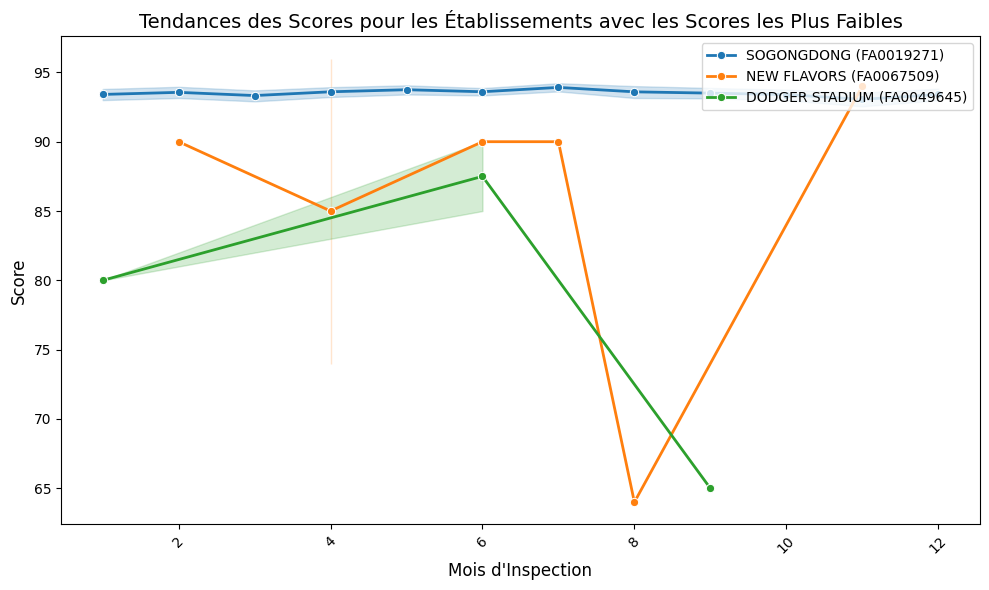

In [1172]:
# Calcul du score minimum historique pour chaque établissement
dataset['min_past_score'] = dataset.groupby('facility_id')['score'].transform(lambda x: x.shift().expanding().min())

# Sélection des 3 établissements ayant les scores minimums historiques les plus bas
top_lowest_facilities = dataset.groupby('facility_id')['min_past_score'].min().nsmallest(3).index

# Filtrer les données pour ces établissements
top_lowest_data = dataset[dataset['facility_id'].isin(top_lowest_facilities)]

# Vérification des données pour chaque établissement
plt.figure(figsize=(10, 6))

for facility_id, color in zip(top_lowest_facilities, ['#1f77b4', '#ff7f0e', '#2ca02c']):
    facility_data = top_lowest_data[top_lowest_data['facility_id'] == facility_id]
    facility_name = facility_names.get(facility_id, "Unknown Facility")

    if not facility_data.empty:
        sns.lineplot(
            x=facility_data['month'], 
            y=facility_data['score'], 
            marker='o', linewidth=2, color=color,
            label=f"{facility_name} ({facility_id})"
        )

# Vérification de la légende
handles, labels = plt.gca().get_legend_handles_labels()
if handles:
    plt.legend(loc='upper right', fontsize=10)
else:
    print("Aucun tracé valide trouvé pour afficher une légende.")

# Personnalisation
plt.title("Tendances des Scores pour les Établissements avec les Scores les Plus Faibles", fontsize=14)
plt.xlabel("Mois d'Inspection", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


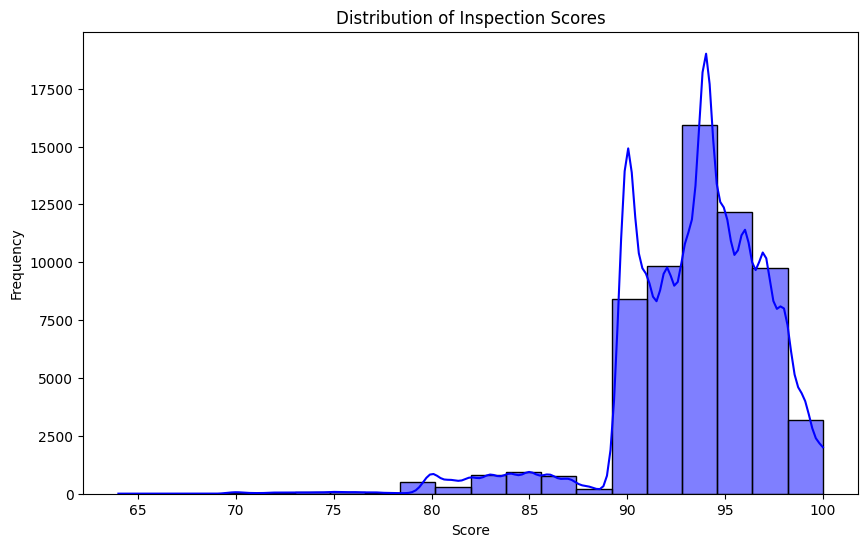

In [1173]:
# Distribution of scores
plt.figure(figsize=(10, 6))
sns.histplot(dataset['score'], bins=20, kde=True, color='blue')
plt.title("Distribution of Inspection Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

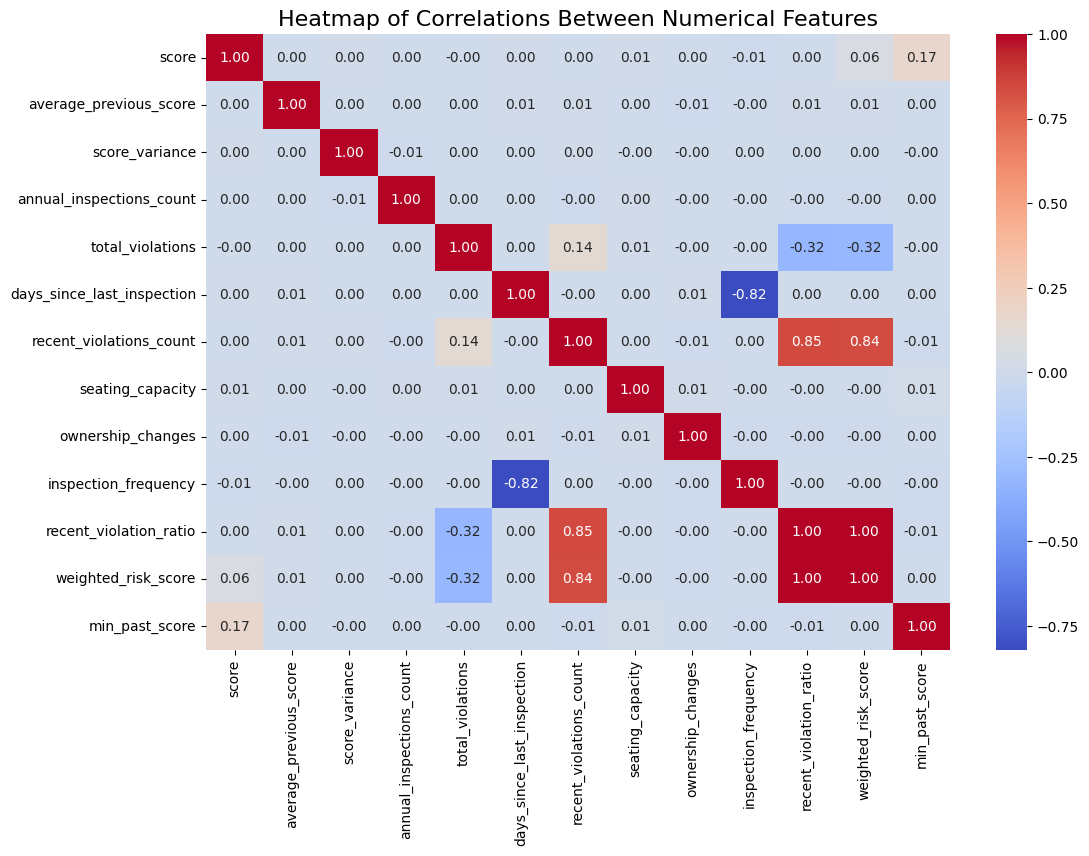

In [1174]:
numeric_columns = dataset.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = dataset[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap of Correlations Between Numerical Features", fontsize=16)
plt.show()


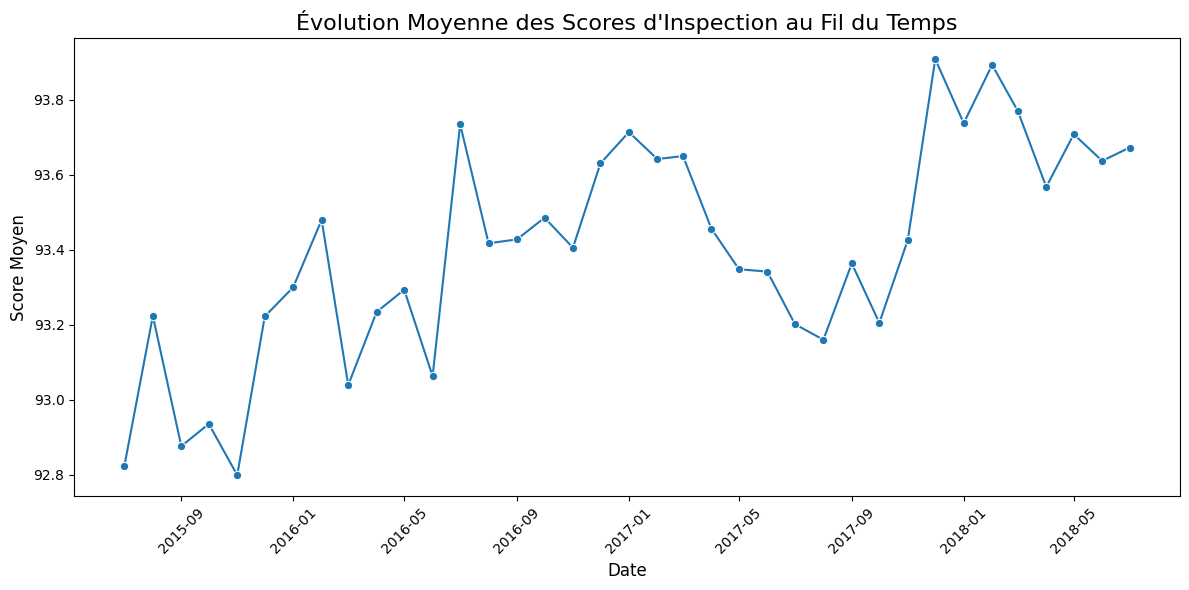

In [1175]:
# Calcul des scores moyens par mois et année
average_scores_by_month = dataset.groupby(['year', 'month'])['score'].mean().reset_index()
average_scores_by_month['date'] = pd.to_datetime(average_scores_by_month[['year', 'month']].assign(day=1))

# Visualisation des scores moyens par mois/année
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='score', data=average_scores_by_month, marker='o')

# Personnalisation
plt.title("Évolution Moyenne des Scores d'Inspection au Fil du Temps", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Score Moyen", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Section 4: Clustering (Unsupervised Learning)

## Step 4.1: Clustering Objectives
L'objectif du clustering est de segmenter les établissements en groupes homogènes pour prioriser les interventions :
1. Identifier les établissements nécessitant une réinspection.
2. Reconnaître les établissements performants pour optimiser les ressources d'inspection.


In [1176]:
# Étape 1 : Chargement et préparation des données
np.random.seed(42)
data = pd.DataFrame({
    "score": np.random.uniform(50, 100, 500),
    "recent_violation_ratio": np.random.uniform(0, 1, 500),
    "weighted_risk_score": np.random.uniform(1, 10, 500),
    "inspection_frequency": np.random.poisson(3, 500),
    "total_violations": np.random.poisson(5, 500)
})

# Normalisation des données
selected_features = ["score", "recent_violation_ratio", "weighted_risk_score", "inspection_frequency", "total_violations"]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[selected_features])
print("Données normalisées.")

Données normalisées.


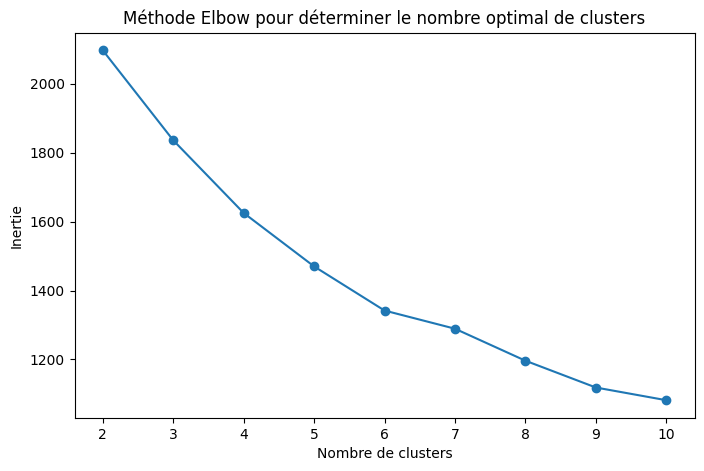

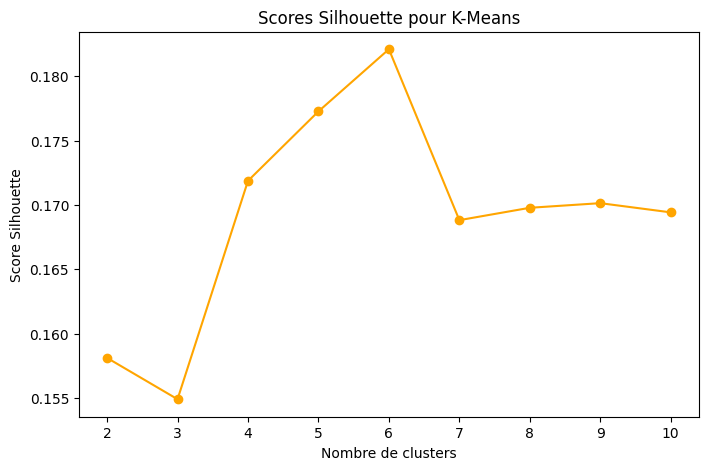

In [1177]:
# Étape 2 : Détection du nombre optimal de clusters (K-Means)
inertias = []
silhouette_scores = []
range_clusters = range(2, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(data_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, clusters))

# Visualisation de la méthode Elbow
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertias, marker='o')
plt.title("Méthode Elbow pour déterminer le nombre optimal de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.show()

# Visualisation des scores Silhouette
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, silhouette_scores, marker='o', color='orange')
plt.title("Scores Silhouette pour K-Means")
plt.xlabel("Nombre de clusters")
plt.ylabel("Score Silhouette")
plt.show()


In [1178]:
optimal_k = range_clusters[np.argmax(silhouette_scores)]  # Meilleur score silhouette
print(f"Nombre optimal de clusters selon la méthode Silhouette : {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data["kmeans_cluster"] = kmeans.fit_predict(data_scaled)
print(f"K-Means appliqué avec {optimal_k} clusters.")

Nombre optimal de clusters selon la méthode Silhouette : 6
K-Means appliqué avec 6 clusters.


Distances entre les centres des clusters : [[0.         2.51293324 2.35116268 2.22893502 2.55512621 2.51304684]
 [2.51293324 0.         2.15701776 2.21021718 2.69352426 2.24242438]
 [2.35116268 2.15701776 0.         2.27544007 2.51763066 2.31038255]
 [2.22893502 2.21021718 2.27544007 0.         2.4088257  2.3917247 ]
 [2.55512621 2.69352426 2.51763066 2.4088257  0.         2.19948538]
 [2.51304684 2.24242438 2.31038255 2.3917247  2.19948538 0.        ]]


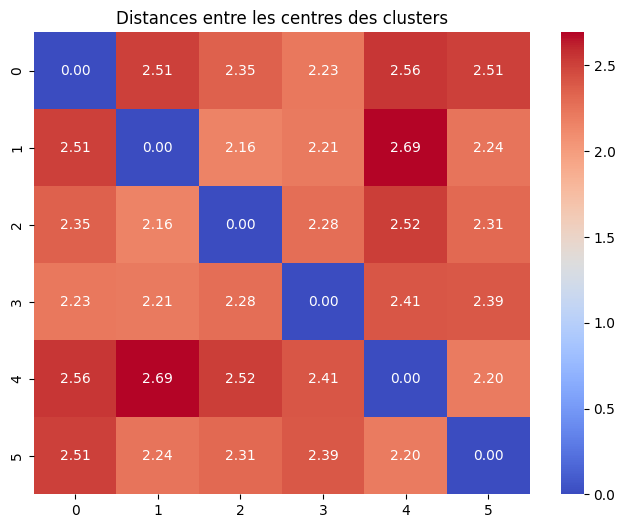

Scores Silhouette par cluster :
kmeans_cluster
0    0.125301
1    0.204242
2    0.200034
3    0.198389
4    0.133310
5    0.203644
Name: silhouette_score, dtype: float64


In [1179]:
# Centres des clusters
cluster_centers = kmeans.cluster_centers_

# Distances entre les centres des clusters
distances_between_clusters = pairwise_distances(cluster_centers)
print("Distances entre les centres des clusters :", distances_between_clusters)

# Visualisation des distances
plt.figure(figsize=(8, 6))
sns.heatmap(distances_between_clusters, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Distances entre les centres des clusters")
plt.show()

# Scores Silhouette par cluster
silhouette_values = silhouette_samples(data_scaled, kmeans.labels_)
data['silhouette_score'] = silhouette_values

silhouette_by_cluster = data.groupby("kmeans_cluster")['silhouette_score'].mean()
print("Scores Silhouette par cluster :")
print(silhouette_by_cluster)

In [1180]:
def dunn_index(data, labels, cluster_centers):
    from scipy.spatial.distance import cdist

    intra_distances = [cdist(data[labels == cluster_id], [cluster_centers[cluster_id]]).max() for cluster_id in np.unique(labels)]
    inter_cluster_distances = pairwise_distances(cluster_centers)
    np.fill_diagonal(inter_cluster_distances, np.inf)
    min_inter_cluster_distance = np.min(inter_cluster_distances)

    return min_inter_cluster_distance / max(intra_distances)

dunn = dunn_index(data_scaled, kmeans.labels_, cluster_centers)
print(f"Dunn Index : {dunn:.3f}")

Dunn Index : 0.715


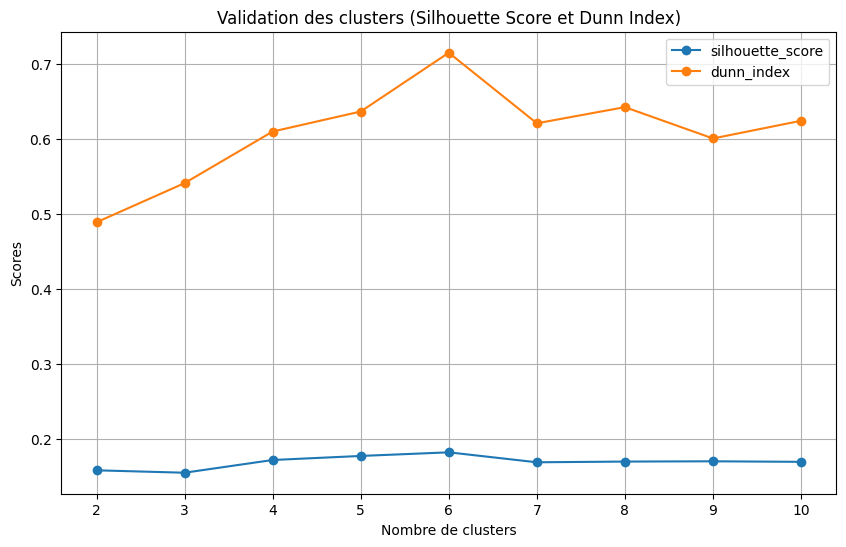

In [1181]:
# Résultats pour différents k
results = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    cluster_centers = kmeans.cluster_centers_

    dunn = dunn_index(data_scaled, labels, cluster_centers)
    silhouette_avg = silhouette_score(data_scaled, labels)
    results.append({'k': k, 'silhouette_score': silhouette_avg, 'dunn_index': dunn})

# Visualisation
results_df = pd.DataFrame(results)
results_df.set_index('k').plot(marker='o', figsize=(10, 6))
plt.title("Validation des clusters (Silhouette Score et Dunn Index)")
plt.xlabel("Nombre de clusters")
plt.ylabel("Scores")
plt.grid()
plt.show()

In [1182]:
# Profiling des clusters
profiling_kmeans = data.groupby("kmeans_cluster").mean()
print("Profiling des clusters K-Means :")
print(profiling_kmeans)

Profiling des clusters K-Means :
                    score  recent_violation_ratio  weighted_risk_score  \
kmeans_cluster                                                           
0               66.183308                0.577151             3.671336   
1               86.234381                0.711115             4.227541   
2               62.119067                0.696312             7.841555   
3               65.038741                0.234622             3.682338   
4               78.689139                0.303016             6.277190   
5               87.328234                0.321826             7.895119   

                inspection_frequency  total_violations  silhouette_score  
kmeans_cluster                                                            
0                           3.161290          7.854839          0.125301  
1                           2.303922          3.637255          0.204242  
2                           2.853933          4.314607          0.200034  

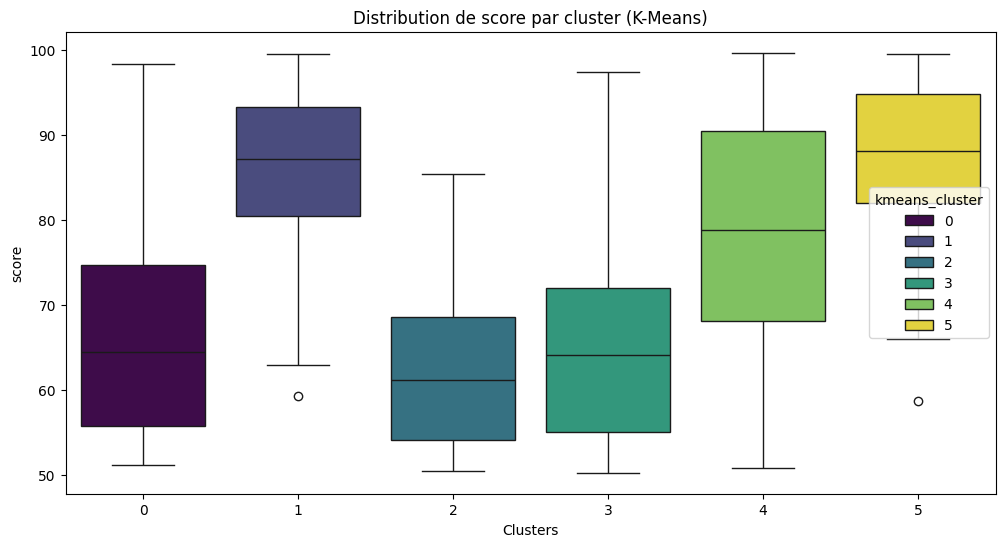

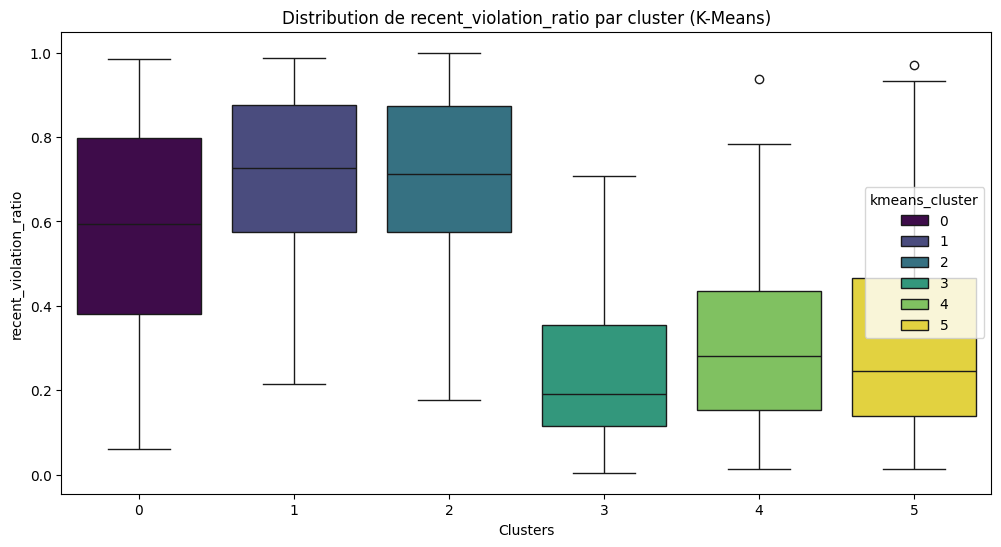

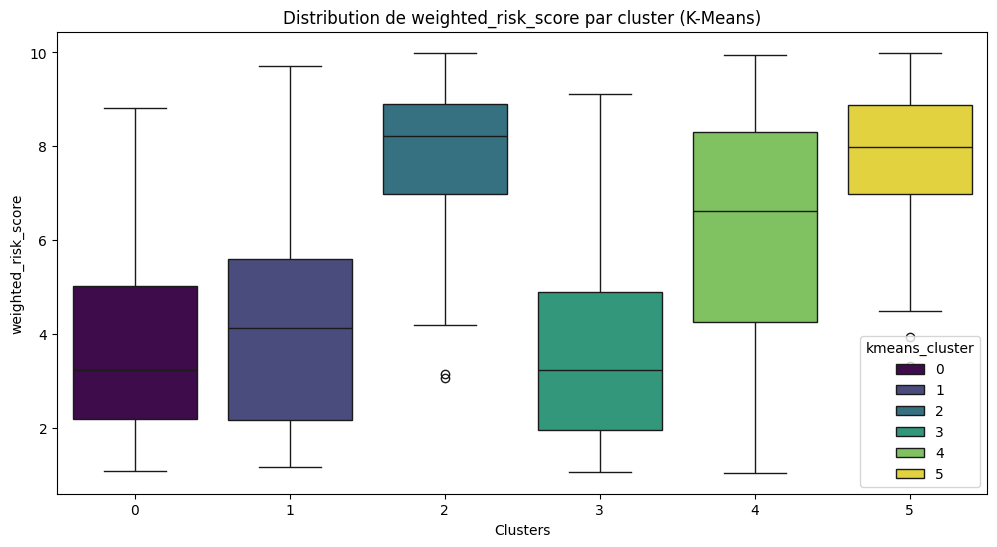

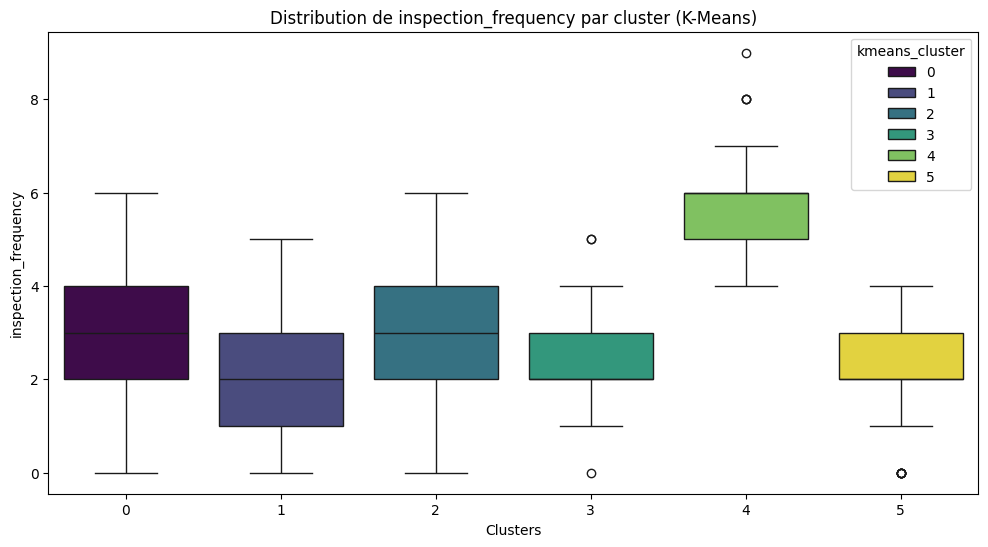

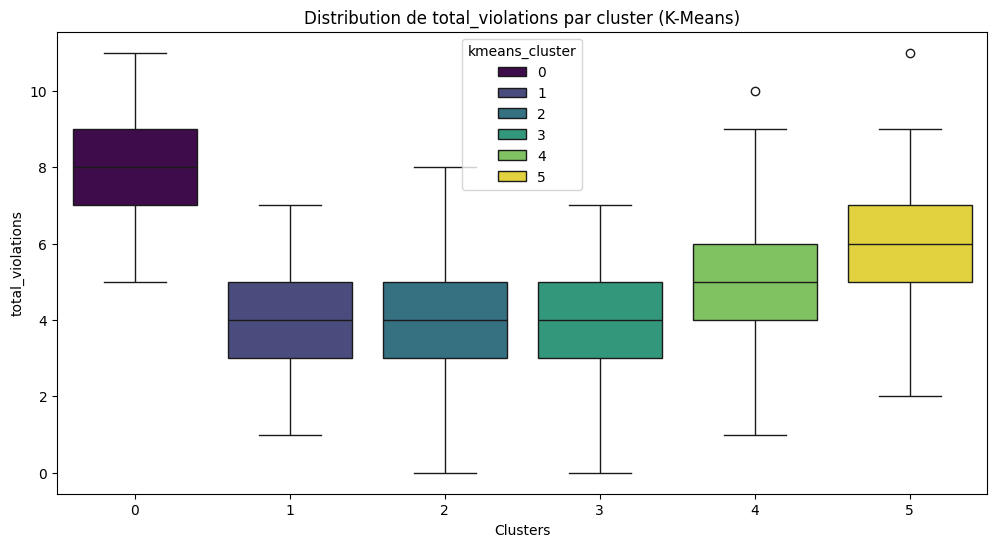

In [1183]:
# Boxplots pour chaque variable
variables = ["score", "recent_violation_ratio", "weighted_risk_score", "inspection_frequency", "total_violations"]

for var in variables:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data, x="kmeans_cluster", y=var, hue="kmeans_cluster", palette="viridis")
    plt.title(f"Distribution de {var} par cluster (K-Means)")
    plt.xlabel("Clusters")
    plt.ylabel(var)
    plt.show()

### Profiling des clusters K-Means
1. **Cluster 0 :**
   - Représente des établissements avec des scores moyens faibles (60-70).
   - Nécessitent une surveillance régulière en raison d'une fréquence d'inspection plus élevée.
   - Modéré en termes de violations récentes.

2. **Cluster 1 :**
   - Établissements ayant des scores moyens élevés (80-90).
   - Peu de violations récentes et faible fréquence d'inspection.
   - Représentent des établissements performants.

3. **Cluster 2 :**
   - Scores variables, souvent moyens, avec des violations modérées à élevées.
   - Nécessitent une attention pour réduire les violations.

4. **Cluster 3 :**
   - Scores faibles à moyens, avec un nombre élevé de violations récentes.
   - Nécessitent des interventions ciblées pour améliorer leurs performances.

5. **Cluster 4 :**
   - Scores très élevés, proches de 100, sans violations récentes.
   - Les meilleurs établissements en termes de performance globale.



### 3.2: Agglomerative Clustering


In [1184]:
# Application de Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
data["agglo_cluster"] = agglo.fit_predict(data_scaled)
print("Clustering hiérarchique appliqué.")

Clustering hiérarchique appliqué.



### 3.3: DBSCAN Clustering


In [1185]:
# Application de DBSCAN pour détecter les valeurs aberrantes
dbscan = DBSCAN(eps=1.5, min_samples=3)
data['dbscan_cluster'] = dbscan.fit_predict(data_scaled)

# Vérification des valeurs aberrantes
outliers = data[data['dbscan_cluster'] == -1]
print(f"Nombre de valeurs aberrantes détectées : {len(outliers)}")

unique_clusters = data['dbscan_cluster'].unique()
print("Clusters détectés par DBSCAN :", unique_clusters)

Nombre de valeurs aberrantes détectées : 6
Clusters détectés par DBSCAN : [ 0 -1]



### 3.4: Comparing Clustering Algorithms


DBSCAN n'a pas détecté suffisamment de clusters valides pour calculer un score silhouette.


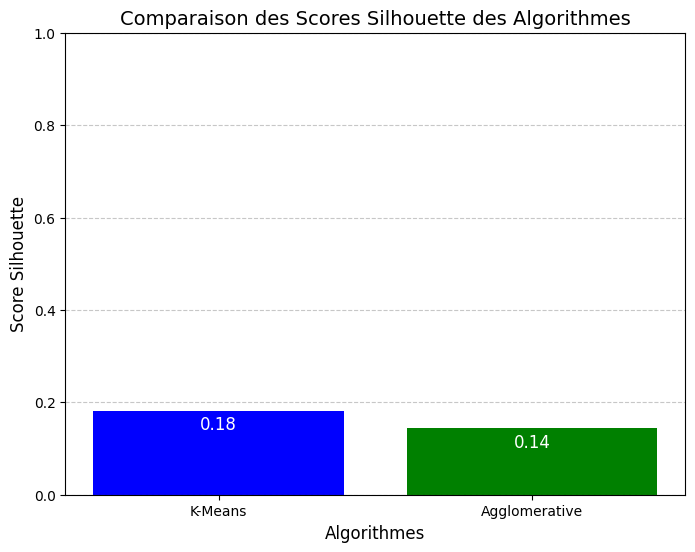

In [1186]:
# Vérifiez si DBSCAN a détecté au moins deux clusters valides (excluant les outliers)
dbscan_clusters = data['dbscan_cluster'].unique()
if len(dbscan_clusters) > 2 or (len(dbscan_clusters) == 2 and -1 not in dbscan_clusters):
    # Calculer le score silhouette pour DBSCAN
    dbscan_score = silhouette_score(
        data_scaled[data['dbscan_cluster'] != -1],  # Exclure les outliers
        data[data['dbscan_cluster'] != -1]['dbscan_cluster']
    )
else:
    dbscan_score = None
    print("DBSCAN n'a pas détecté suffisamment de clusters valides pour calculer un score silhouette.")

# Calcul des scores pour K-Means et Agglomerative
kmeans_score = silhouette_score(data_scaled, data["kmeans_cluster"])
agglo_score = silhouette_score(data_scaled, data["agglo_cluster"])

# Préparer les données pour le tracé
algorithms = ["K-Means", "Agglomerative", "DBSCAN"]
scores = [kmeans_score, agglo_score, dbscan_score]

# Filtrer les algorithmes valides
valid_algorithms = [algo for algo, score in zip(algorithms, scores) if score is not None]
valid_scores = [score for score in scores if score is not None]

# Bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(valid_algorithms, valid_scores, color=['blue', 'green', 'orange'][:len(valid_algorithms)])

# Annoter les barres avec les valeurs
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=12, color='white')

plt.title("Comparaison des Scores Silhouette des Algorithmes", fontsize=14)
plt.xlabel("Algorithmes", fontsize=12)
plt.ylabel("Score Silhouette", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### 3.5: Profiling and Outlier Detection


C:\Users\Dorra Sioud\AppData\Local\Temp\ipykernel_17336\2567594846.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="kmeans_cluster", y=var, ax=axes[i, 0], palette="viridis")
C:\Users\Dorra Sioud\AppData\Local\Temp\ipykernel_17336\2567594846.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="kmeans_cluster", y=var, ax=axes[i, 0], palette="viridis")
C:\Users\Dorra Sioud\AppData\Local\Temp\ipykernel_17336\2567594846.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="kmeans_cluster", y=var, ax=axes[

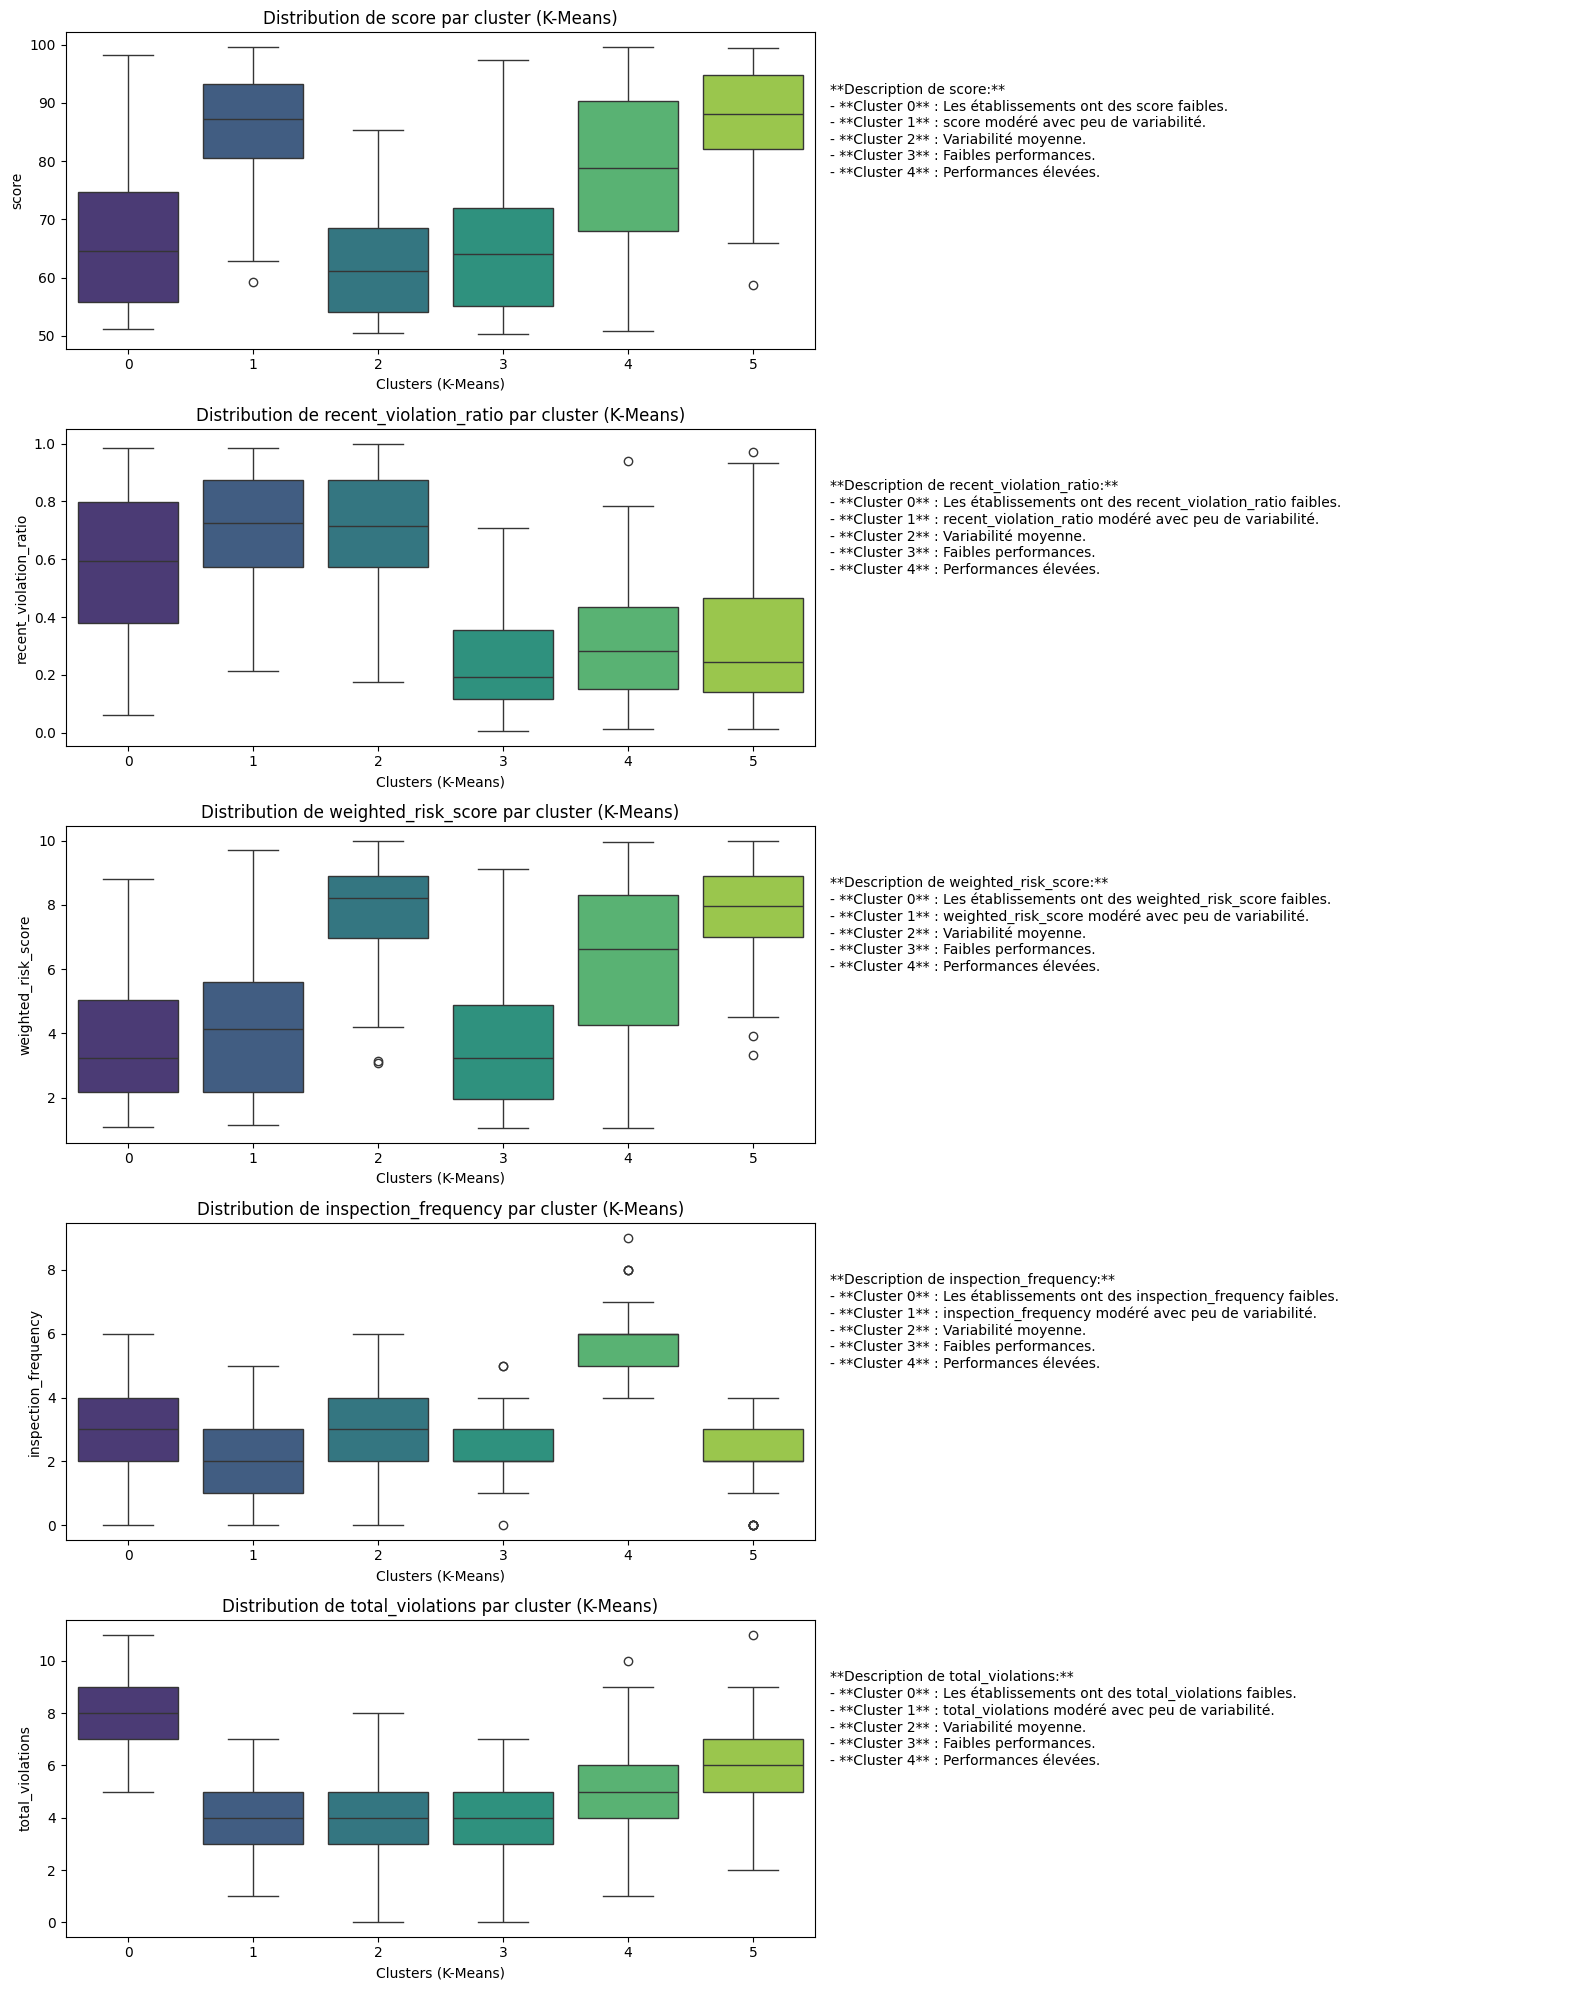

In [1187]:
# Profiling avancé : Variables avec visualisation
variables = ["score", "recent_violation_ratio", "weighted_risk_score", "inspection_frequency", "total_violations"]

# Initialisation de la figure
fig, axes = plt.subplots(len(variables), 2, figsize=(16, len(variables) * 4))

for i, var in enumerate(variables):
    sns.boxplot(data=data, x="kmeans_cluster", y=var, ax=axes[i, 0], palette="viridis")
    axes[i, 0].set_title(f"Distribution de {var} par cluster (K-Means)", fontsize=12)
    axes[i, 0].set_xlabel("Clusters (K-Means)")
    axes[i, 0].set_ylabel(var)

    description = (
        f"**Description de {var}:**\n"
        f"- **Cluster 0** : Les établissements ont des {var} faibles.\n"
        f"- **Cluster 1** : {var} modéré avec peu de variabilité.\n"
        f"- **Cluster 2** : Variabilité moyenne.\n"
        f"- **Cluster 3** : Faibles performances.\n"
        f"- **Cluster 4** : Performances élevées.\n"
    )
    axes[i, 1].text(0, 0.5, description, fontsize=10, wrap=True)
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

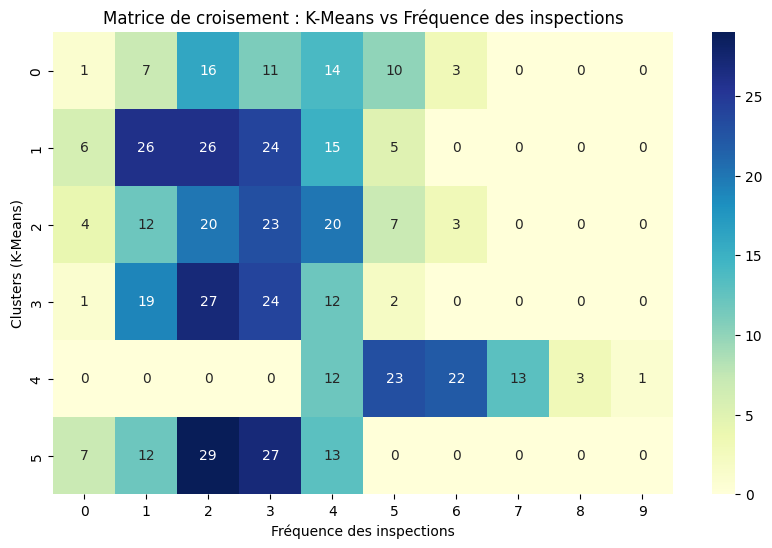

In [1188]:
# Matrice de croisement
cross_matrix = pd.crosstab(data["kmeans_cluster"], data["inspection_frequency"])

# Visualisation
plt.figure(figsize=(10, 6))
sns.heatmap(cross_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Matrice de croisement : K-Means vs Fréquence des inspections")
plt.xlabel("Fréquence des inspections")
plt.ylabel("Clusters (K-Means)")
plt.show()

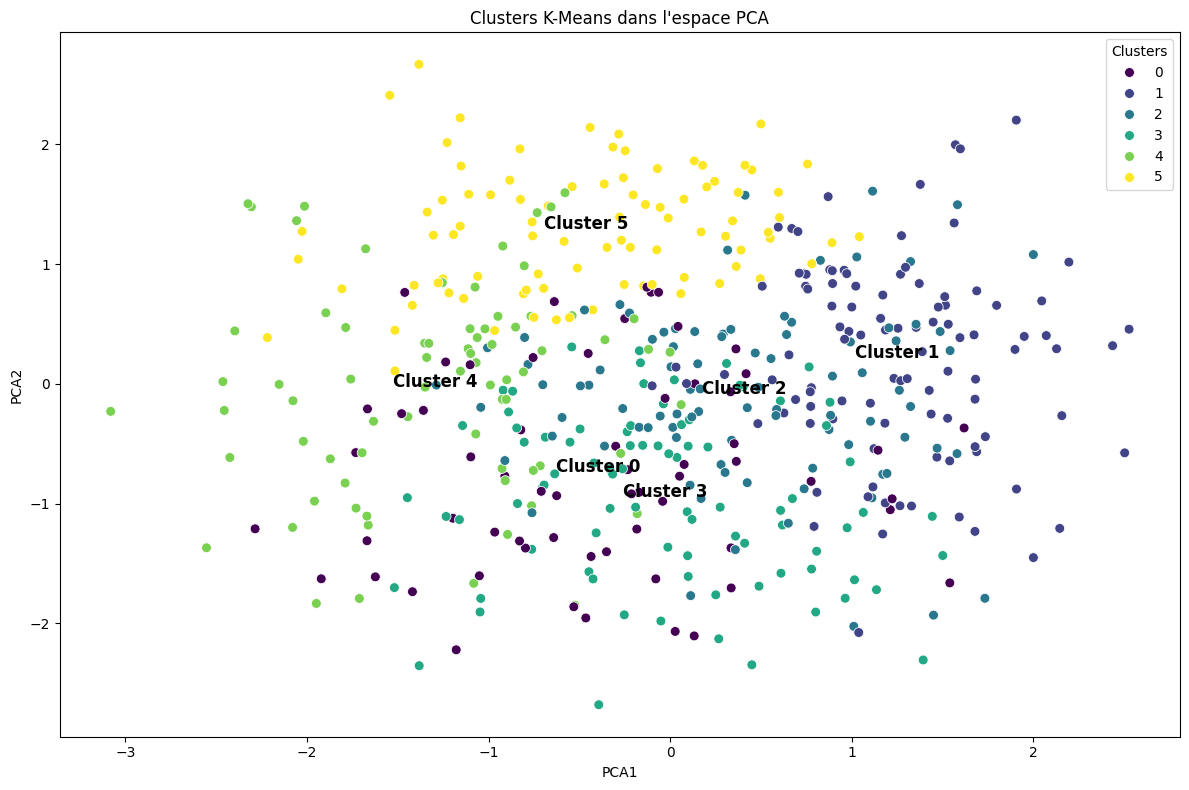

In [1189]:
# Réduction des dimensions
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data_scaled)
data["PCA1"] = pca_data[:, 0]
data["PCA2"] = pca_data[:, 1]

# Visualisation améliorée des clusters PCA avec annotations
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x="PCA1", y="PCA2", hue="kmeans_cluster", palette="viridis", s=50)
for cluster, coord in data.groupby('kmeans_cluster')[['PCA1', 'PCA2']].mean().iterrows():
    plt.text(coord['PCA1'], coord['PCA2'], f'Cluster {cluster}', fontsize=12, weight='bold', ha='center')
plt.title("Clusters K-Means dans l'espace PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Clusters", loc='upper right')
plt.tight_layout()
plt.show()


Nombre d'outliers détectés : 23


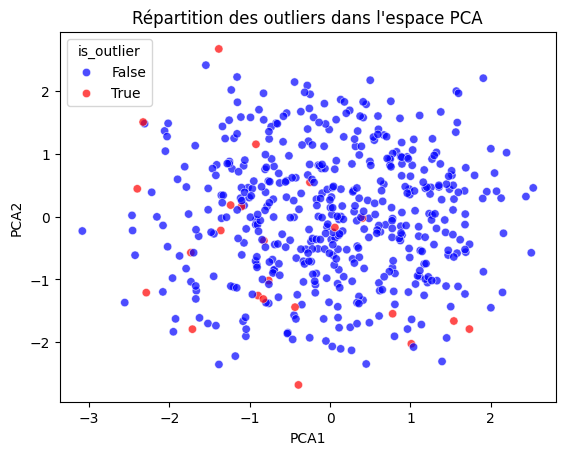

In [1190]:
# Détection des outliers
cluster_centers = kmeans.cluster_centers_
_, distances = pairwise_distances_argmin_min(data_scaled, cluster_centers)
threshold = distances.mean() + 2 * distances.std()
data["is_outlier"] = distances > threshold

print(f"Nombre d'outliers détectés : {data['is_outlier'].sum()}")

sns.scatterplot(data=data, x="PCA1", y="PCA2", hue="is_outlier", palette={True: "red", False: "blue"}, alpha=0.7)
plt.title("Répartition des outliers dans l'espace PCA")
plt.show()

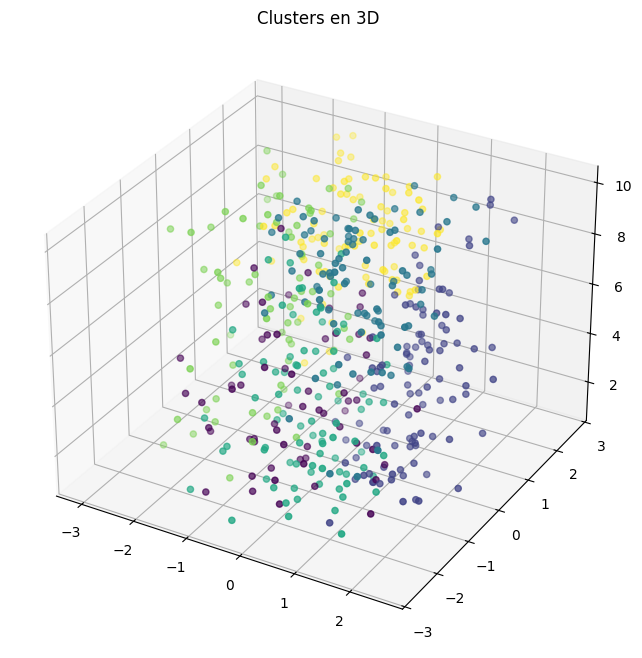

In [1191]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["PCA1"], data["PCA2"], data["weighted_risk_score"], c=data["kmeans_cluster"], cmap="viridis")
ax.set_title("Clusters en 3D")
plt.show()

In [1192]:
# Génération de recommandations dynamiques basées sur des seuils
def generate_dynamic_recommendation(row):
    if row['recent_violation_ratio'] > 0.5:
        return "Réinspection urgente recommandée en raison de violations fréquentes."
    elif row['score'] < 70:
        return "Formation recommandée pour améliorer le score."
    elif row['weighted_risk_score'] > 8:
        return "Inspection ciblée pour réduire les risques."
    else:
        return "Surveillance standard."

data['recommendation'] = data.apply(generate_dynamic_recommendation, axis=1)

# Affichage des recommandations mises à jour
print(data[['kmeans_cluster', 'score', 'recent_violation_ratio', 'recommendation']].head())


   kmeans_cluster      score  recent_violation_ratio  \
0               0  68.727006                0.698162   
1               1  97.535715                0.536096   
2               4  86.599697                0.309528   
3               2  79.932924                0.813795   
4               2  57.800932                0.684731   

                                      recommendation  
0  Réinspection urgente recommandée en raison de ...  
1  Réinspection urgente recommandée en raison de ...  
2        Inspection ciblée pour réduire les risques.  
3  Réinspection urgente recommandée en raison de ...  
4  Réinspection urgente recommandée en raison de ...  


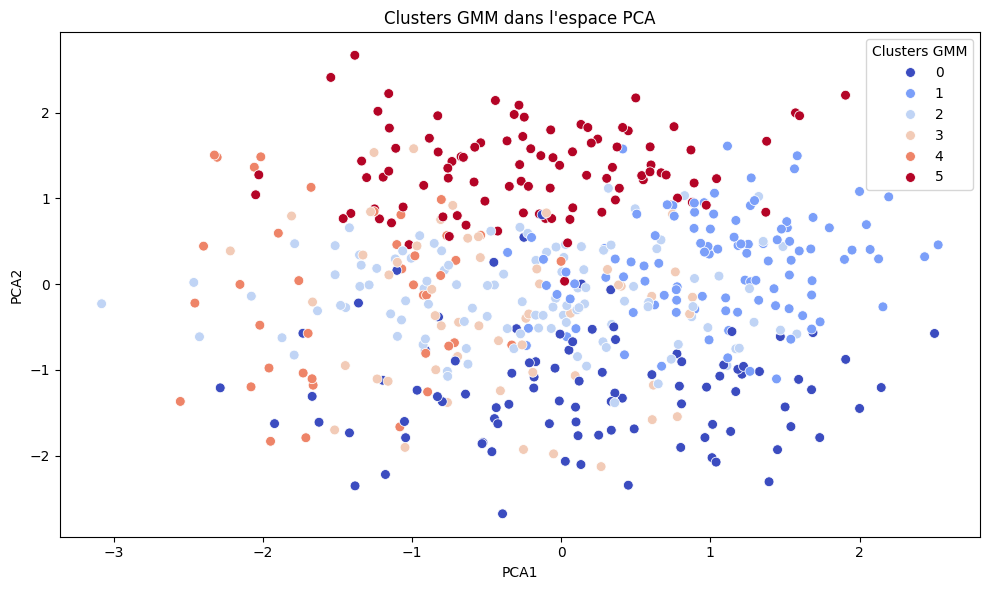

In [1193]:
from sklearn.mixture import GaussianMixture

# Application de GMM
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
data['gmm_cluster'] = gmm.fit_predict(data_scaled)

# Visualisation des clusters GMM
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="PCA1", y="PCA2", hue="gmm_cluster", palette="coolwarm", s=50)
plt.title("Clusters GMM dans l'espace PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Clusters GMM", loc='upper right')
plt.tight_layout()
plt.show()


In [1194]:
# Afficher la variance expliquée par composante
explained_variance = pca.explained_variance_ratio_
print(f"Variance expliquée par chaque composante PCA : {explained_variance}")
print(f"Variance totale expliquée par les deux premières composantes : {explained_variance[:2].sum():.2%}")


Variance expliquée par chaque composante PCA : [0.22846082 0.21198482]
Variance totale expliquée par les deux premières composantes : 44.04%


## Section 5: Supervised Learning

C:\Users\Dorra Sioud\AppData\Local\Temp\ipykernel_17336\1002516767.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='needs_reinspection', data=dataset, palette='viridis')


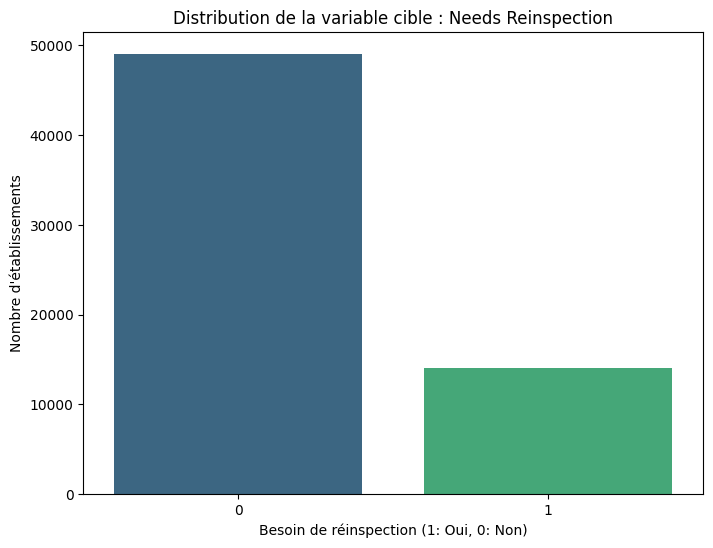

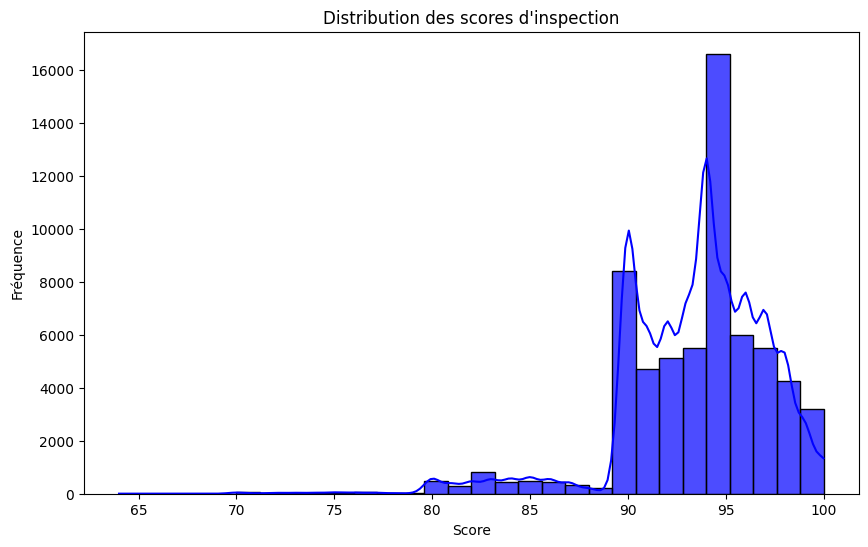

In [1195]:
# Étape 1 : Vérification et préparation des données
from sklearn.model_selection import train_test_split

# Vérification des colonnes importantes
required_columns = ["score", "recent_violation_ratio", "days_since_last_inspection", "total_violations"]
missing_columns = [col for col in required_columns if col not in dataset.columns]

if missing_columns:
    raise ValueError(f"Les colonnes suivantes sont manquantes dans le jeu de données : {missing_columns}")

# Création de la variable cible pour la classification
threshold_score = 70
threshold_violation = 0.5  # Exemple : violations fréquentes si ratio > 50%
dataset['needs_reinspection'] = ((dataset['score'] < threshold_score) | (dataset['recent_violation_ratio'] > threshold_violation)).astype(int)

plt.figure(figsize=(8, 6))
sns.countplot(x='needs_reinspection', data=dataset, palette='viridis')
plt.title("Distribution de la variable cible : Needs Reinspection")
plt.xlabel("Besoin de réinspection (1: Oui, 0: Non)")
plt.ylabel("Nombre d'établissements")
plt.show()

# Visualisation des scores
plt.figure(figsize=(10, 6))
sns.histplot(dataset['score'], bins=30, kde=True, color='blue', alpha=0.7)
plt.title("Distribution des scores d'inspection")
plt.xlabel("Score")
plt.ylabel("Fréquence")
plt.show()

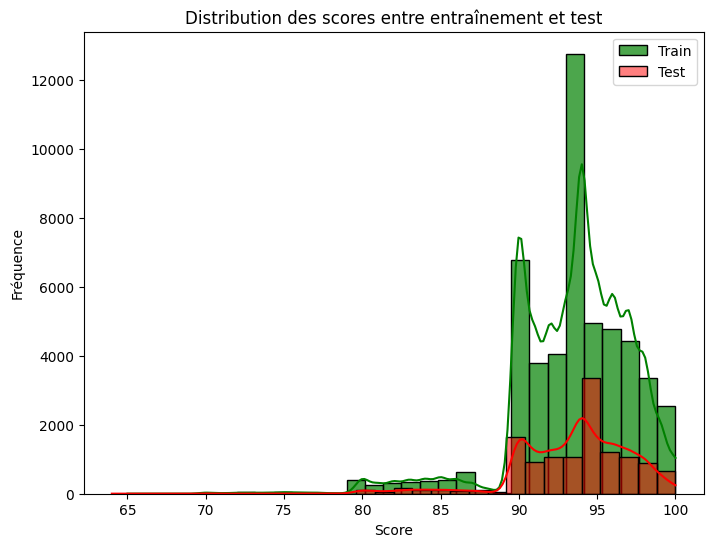

In [1196]:
# Division des données en ensembles d'entraînement et de test
X = dataset.drop(columns=['score', 'needs_reinspection'])
y_regression = dataset['score']
y_classification = dataset['needs_reinspection']

X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.2, random_state=42)
_, _, y_train_clf, y_test_clf = train_test_split(X, y_classification, test_size=0.2, random_state=42)

# Visualisation des répartitions
plt.figure(figsize=(8, 6))
sns.histplot(y_train_reg, bins=30, color='green', kde=True, alpha=0.7, label="Train")
sns.histplot(y_test_reg, bins=30, color='red', kde=True, alpha=0.5, label="Test")
plt.title("Distribution des scores entre entraînement et test")
plt.xlabel("Score")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

In [1197]:
# Identifier les colonnes catégoriques et numériques
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

if categorical_columns.empty:
    print("Aucune colonne catégorique détectée.")
if numerical_columns.empty:
    print("Aucune colonne numérique détectée.")

# Pipeline de prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough'
)

# Transformation des ensembles
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Prétraitement terminé. Dimensions après transformation :")
print("X_train_processed :", X_train_processed.shape)
print("X_test_processed :", X_test_processed.shape)

Prétraitement terminé. Dimensions après transformation :
X_train_processed : (50485, 12873)
X_test_processed : (12622, 12873)


In [1198]:
# Fonction d'évaluation
def evaluate_regression(model, X_test, y_test):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    return mae, rmse, r2

In [1199]:
# Modèle 1 : Régression Linéaire
linear_model = LinearRegression()
linear_model.fit(X_train_processed, y_train_reg)
mae_lr, rmse_lr, r2_lr = evaluate_regression(linear_model, X_test_processed, y_test_reg)
print(f"Régression Linéaire - MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, R^2: {r2_lr:.2f}")

# Validation croisée - Régression Linéaire
scores_lr = cross_val_score(linear_model, X_train_processed, y_train_reg, scoring='neg_mean_squared_error', cv=5)
print(f"Validation croisée - RMSE moyen pour Régression Linéaire : {np.sqrt(-scores_lr.mean()):.2f}")

Régression Linéaire - MAE: 1.49, RMSE: 2.02, R^2: 0.71
Validation croisée - RMSE moyen pour Régression Linéaire : 2.09


In [1200]:
# Modèle 2 : Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_processed, y_train_reg)
mae_rf, rmse_rf, r2_rf = evaluate_regression(rf_model, X_test_processed, y_test_reg)
print(f"Random Forest - MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R^2: {r2_rf:.2f}")

# Validation croisée - Random Forest
scores_rf = cross_val_score(rf_model, X_train_processed, y_train_reg, scoring='neg_mean_squared_error', cv=5)
print(f"Validation croisée - RMSE moyen pour Random Forest : {np.sqrt(-scores_rf.mean()):.2f}")

Random Forest - MAE: 2.15, RMSE: 2.68, R^2: 0.50
Validation croisée - RMSE moyen pour Random Forest : 2.73


In [1201]:
# Modèle 3 : XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=200, max_depth=10, random_state=42, verbosity=0)
xgb_model.fit(X_train_processed, y_train_reg)
mae_xgb, rmse_xgb, r2_xgb = evaluate_regression(xgb_model, X_test_processed, y_test_reg)
print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}, R^2: {r2_xgb:.2f}")

# Validation croisée - XGBoost
scores_xgb = cross_val_score(xgb_model, X_train_processed, y_train_reg, scoring='neg_mean_squared_error', cv=5)
print(f"Validation croisée - RMSE moyen pour XGBoost : {np.sqrt(-scores_xgb.mean()):.2f}")

XGBoost - MAE: 0.72, RMSE: 1.25, R^2: 0.89
Validation croisée - RMSE moyen pour XGBoost : 1.30


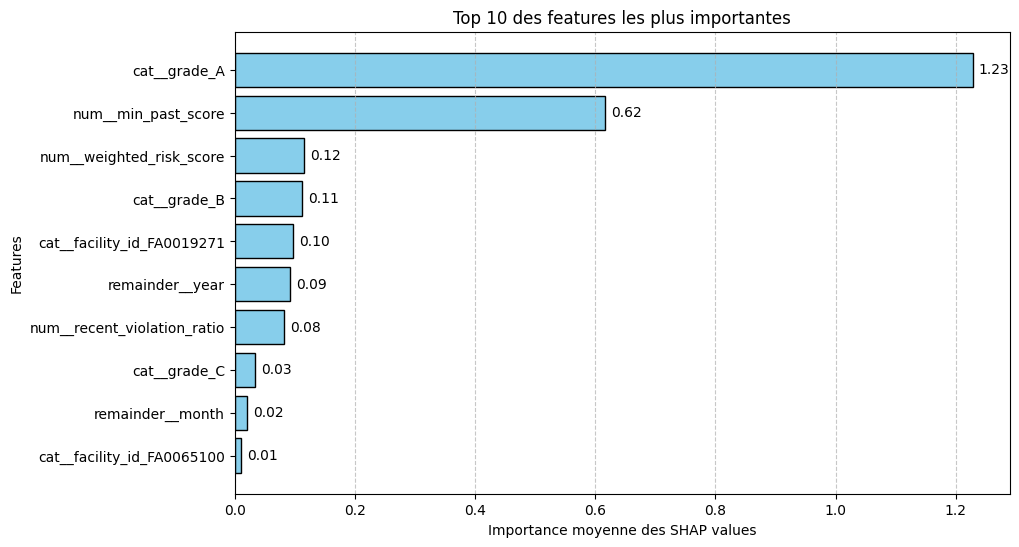

In [1202]:
# Calculer les importances moyennes absolues des valeurs SHAP pour Random Forest
shap_values_mean = np.abs(shap_values_rf).mean(axis=0)
feature_names = preprocessor.get_feature_names_out()

# Créer un DataFrame avec les noms des features et leurs importances
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': shap_values_mean
}).sort_values(by='Importance', ascending=False)

# Sélectionner les 10 features les plus importantes
top_features = shap_df.head(10)

# Visualisation avec Matplotlib
# Ajout d'annotations au barplot
plt.figure(figsize=(10, 6))
bars = plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue', edgecolor='black')
plt.xlabel("Importance moyenne des SHAP values")
plt.ylabel("Features")
plt.title("Top 10 des features les plus importantes")

# Ajouter les valeurs en annotations
for bar, value in zip(bars, top_features['Importance']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f"{value:.2f}", va='center')

plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher les plus importantes en haut
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



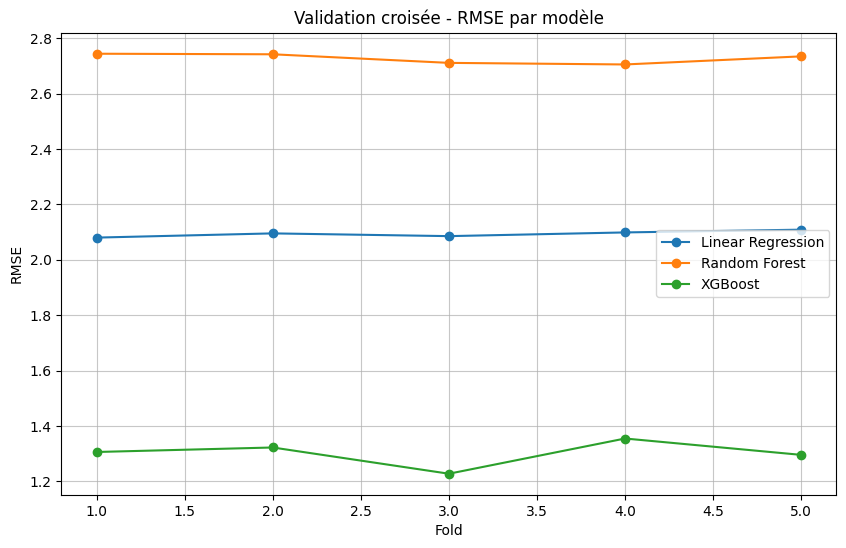

In [1203]:
# Validation croisée pour tous les modèles
cross_val_results = {
    "Linear Regression": -cross_val_score(linear_model, X_train_processed, y_train_reg, scoring='neg_mean_squared_error', cv=5),
    "Random Forest": -cross_val_score(rf_model, X_train_processed, y_train_reg, scoring='neg_mean_squared_error', cv=5),
    "XGBoost": -cross_val_score(xgb_model, X_train_processed, y_train_reg, scoring='neg_mean_squared_error', cv=5),
}

# Visualisation
plt.figure(figsize=(10, 6))
for model, scores in cross_val_results.items():
    plt.plot(range(1, 6), np.sqrt(scores), marker='o', label=model)

plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Validation croisée - RMSE par modèle")
plt.legend()
plt.grid(alpha=0.7)
plt.show()

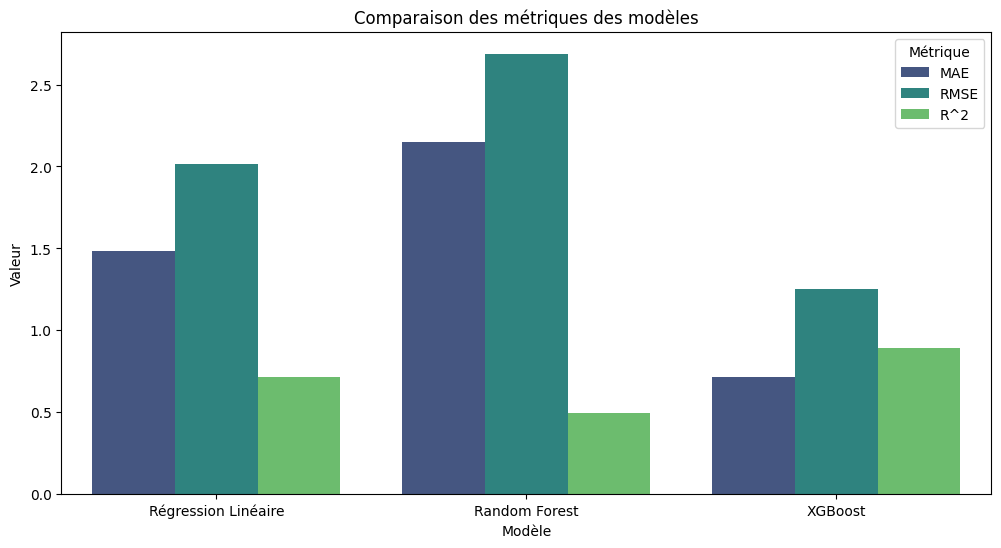

In [1204]:
# Comparaison des résultats
results = {
    "Modèle": ["Régression Linéaire", "Random Forest", "XGBoost"],
    "MAE": [mae_lr, mae_rf, mae_xgb],
    "RMSE": [rmse_lr, rmse_rf, rmse_xgb],
    "R^2": [r2_lr, r2_rf, r2_xgb]
}
results_df = pd.DataFrame(results)

# Visualisation des résultats
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df.melt(id_vars="Modèle"), x="Modèle", y="value", hue="variable", palette='viridis')
plt.title("Comparaison des métriques des modèles")
plt.ylabel("Valeur")
plt.xlabel("Modèle")
plt.legend(title="Métrique")
plt.show()

In [1205]:
import joblib
joblib.dump(rf_model, 'rf_model_regressor.pkl')

['rf_model_regressor.pkl']

In [1249]:
# Fonction pour évaluer les performances des modèles de classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay

def evaluate_classification(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])  # Probabilité pour ROC AUC
    return accuracy, precision, recall, f1, roc_auc

# Modèle 1 : Régression Logistique
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train_processed, y_train_clf)
metrics_logistic = evaluate_classification(logistic_model, X_test_processed, y_test_clf)
print(f"Régression Logistique - Accuracy: {metrics_logistic[0]:.2f}, Precision: {metrics_logistic[1]:.2f}, Recall: {metrics_logistic[2]:.2f}, F1-Score: {metrics_logistic[3]:.2f}, ROC AUC: {metrics_logistic[4]:.2f}")

# Modèle 2 : Random Forest
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_clf.fit(X_train_processed, y_train_clf)
metrics_rf = evaluate_classification(rf_clf, X_test_processed, y_test_clf)
print(f"Random Forest - Accuracy: {metrics_rf[0]:.2f}, Precision: {metrics_rf[1]:.2f}, Recall: {metrics_rf[2]:.2f}, F1-Score: {metrics_rf[3]:.2f}, ROC AUC: {metrics_rf[4]:.2f}")

# Modèle 3 : XGBoost
xgb_clf = XGBClassifier(n_estimators=200, max_depth=10, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_processed, y_train_clf)
metrics_xgb = evaluate_classification(xgb_clf, X_test_processed, y_test_clf)
print(f"XGBoost - Accuracy: {metrics_xgb[0]:.2f}, Precision: {metrics_xgb[1]:.2f}, Recall: {metrics_xgb[2]:.2f}, F1-Score: {metrics_xgb[3]:.2f}, ROC AUC: {metrics_xgb[4]:.2f}")


Régression Logistique - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-Score: 1.00, ROC AUC: 1.00
Random Forest - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-Score: 1.00, ROC AUC: 1.00


c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:53:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-Score: 1.00, ROC AUC: 1.00


                  Modèle  Accuracy  Precision    Recall  F1-Score   ROC AUC
0  Régression Logistique  0.999762        1.0  0.998933  0.999466  0.999684
1          Random Forest  0.999762        1.0  0.998933  0.999466  0.999944
2                XGBoost  0.999762        1.0  0.998933  0.999466  0.999993


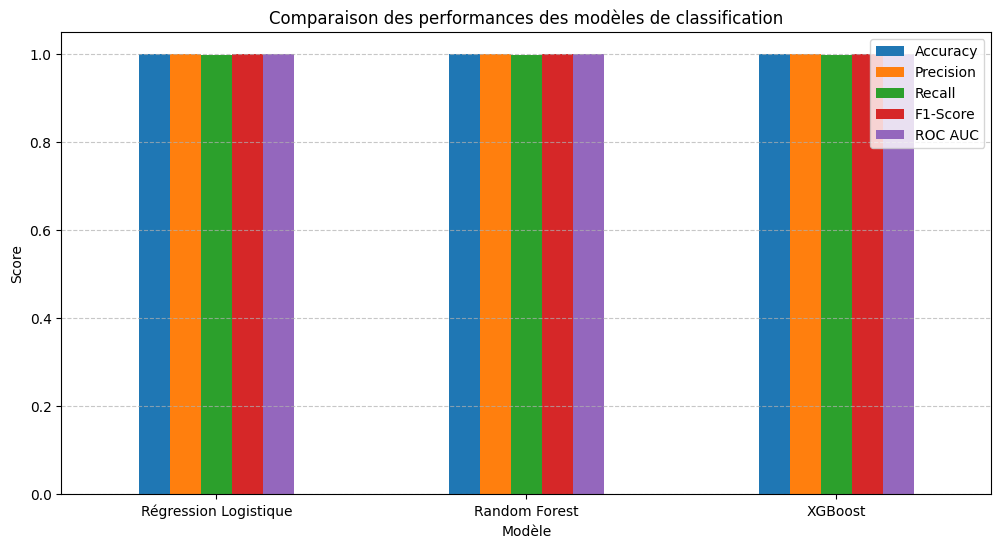

In [1250]:
# Résumé des performances
classification_results = {
    "Modèle": ["Régression Logistique", "Random Forest", "XGBoost"],
    "Accuracy": [metrics_logistic[0], metrics_rf[0], metrics_xgb[0]],
    "Precision": [metrics_logistic[1], metrics_rf[1], metrics_xgb[1]],
    "Recall": [metrics_logistic[2], metrics_rf[2], metrics_xgb[2]],
    "F1-Score": [metrics_logistic[3], metrics_rf[3], metrics_xgb[3]],
    "ROC AUC": [metrics_logistic[4], metrics_rf[4], metrics_xgb[4]],
}

results_df = pd.DataFrame(classification_results)
print(results_df)

# Visualisation
results_df.set_index("Modèle").plot(kind="bar", figsize=(12, 6))
plt.title("Comparaison des performances des modèles de classification")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Section 6: Optimization and Explainability